## Simulated Washout in-silico DNA vs RIBO1C (reverse strand)
### Position: M13mp18:4996

A total of 6 subsampled BAM files were produced mixing in different percentages of reads mapping on the reverse strand coming from both DNA_only (2023) and RIBO1C runs. For each mixed subsampled BAM file, a fixed amount of about 100k reads were used using increasing percentages of DNA reads to simulate an in-silico "washout" effect (0, 20, 40, 60, 80, 100 % of DNA reads vs RIBO1C reads). The site used for this analysis was the M13mp18:4996, which is the expected incorporation site for the rG in RIBO1B construct. Here complement bases are shown.

In [1]:
# importing basic modules
import pandas as pd
import pysam
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
from glob import glob

# to plot better figures
plt.tight_layout()

# ---------- defining Utils Functions --------------- #

def get_results_list(bam_file_path, contig, start_pos_1_based, end_pos_1_based):
    bam_file = pysam.AlignmentFile(bam_file_path)
    start_pos_0_based = start_pos_1_based - 1
    end_pos_0_based = end_pos_1_based
    
    result = []
    for pileupcolumn in bam_file.pileup(contig, start_pos_0_based, end_pos_0_based, truncate=True, min_base_quality=0, max_depth=10000000):
        result.append(pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True))
    bam_file.close()
    
    return result


def get_stats(result_list_single_pos, verbose=True):
    T_count = 0
    C_count = 0
    G_count = 0
    A_count = 0
    del_count = 0
    for i in result_list_single_pos:
        if i.lower() == "t":
            T_count += 1
        elif i.lower() == "c":
            C_count += 1
        elif i.lower() == "g":
            G_count += 1
        elif i.lower() == "a":
            A_count += 1
        if i.lower() == "*":
            del_count += 1
        if "+" in i.lower():
            i_splitted = i.lower().split("+")
            if i_splitted[0] == "t":
                T_count += 1
            elif i_splitted[0] == "c":
                C_count += 1
            elif i_splitted[0] == "g":
                G_count += 1
            elif i_splitted[0]  == "a":
                A_count += 1
        if "-" in i.lower():
            i_splitted = i.lower().split("-")
            if i_splitted[0] == "t":
                T_count += 1
            elif i_splitted[0] == "c":
                C_count += 1
            elif i_splitted[0] == "g":
                G_count += 1
            elif i_splitted[0]  == "a":
                A_count += 1
                
    if verbose:
        print("T", T_count)
        print("C", C_count)
        print("G", G_count)
        print("A", A_count)
        print("Deletions", del_count)
    
    output = [T_count, C_count, G_count, A_count, del_count]
    return output


def get_insertions(bam_file_path, contig, start_pos_1_based, end_pos_1_based):
    bam_file = pysam.AlignmentFile(bam_file_path)
    start_pos_0_based = start_pos_1_based - 2 # -2 cause we want to calculate insertion of the previous reference positions in 0-based index
    end_pos_0_based = end_pos_1_based - 1 # -1 cause we want to calculate insertion of the previous reference positions in 0-based index with right opened intervals (pythonic way)
    
    #start_time = datetime.now()
    result = []
    for pileupcolumn in bam_file.pileup(contig, start_pos_0_based, end_pos_0_based, truncate=True, min_base_quality=0, max_depth=10000000):
        result.append(pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True))
    #stop_time = datetime.now()
    bam_file.close()
    
    final_output_insertions = []
    for pos in result:
        ins_count = 0
        for read in pos:
            if "+" in read.lower():
                ins_count += 1
        final_output_insertions.append(ins_count)
    return final_output_insertions


def calc_freq_bases(df):
    freq = pd.DataFrame(df.iloc[:,0:6].values / np.array(df.iloc[:,0:6].sum(axis=1).values).reshape(df.shape[0],1), 
             columns=["T_freq", "C_freq", "G_freq", "A_freq", "del_freq", "ins_freq"])
    freq["index"] = df.index.to_list()
    freq.set_index("index", inplace=True)
    df_with_freq = pd.concat([df, freq], axis=1)
    return df_with_freq


def get_stats_region(result_list_region, start_pos_1_based=None, stop_pos_1_based=None):
    final_output = []
    for i in result_list_region:
        output = get_stats(i, verbose=False)
        final_output.append(output)
    df_final_output = pd.DataFrame(final_output, columns=["T_count", "C_count", "G_count", "A_count", "del_count"])
    if start_pos_1_based != None and stop_pos_1_based != None:
        index = range(start_pos_1_based, stop_pos_1_based+1)
        df_final_output.index = index
    return df_final_output


def get_stats_from_region(bam_file_path, contig, start_pos_1_based, end_pos_1_based):
    start_time = datetime.now()
    r = get_results_list(bam_file_path, contig, start_pos_1_based, end_pos_1_based)
    df_r = get_stats_region(r, start_pos_1_based, end_pos_1_based)
    insertions = get_insertions(bam_file_path, contig, start_pos_1_based, end_pos_1_based)
    df_r["ins_freq"] = insertions
    df_r_freq = calc_freq_bases(df_r)
    stop_time = datetime.now()
    print(f"[{datetime.now()}] Elapsed time: {stop_time - start_time}", flush=True)
    return df_r_freq

def get_reverse_complment(seq):
    rules = {"A":"T", "T":"A", "G":"C", "C":"G"}
    rev_compl_seq = []
    for b in seq:
        rev_compl_seq.append(rules[b])
    # convert to string
    rev_compl_seq = "".join(rev_compl_seq)
    return rev_compl_seq

<Figure size 432x288 with 0 Axes>

In [3]:
# print mixed datasets produced mixing 100:0; 80:20; 60:40; 40:60; 20:80; 0:100 DNAonly vs RIBO1C reads.
# define ordered bam list
bam_list = [os.path.join("/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer", f"mix_dna_ribo1c_{x}_{100-x}.reverse.bam") for x in [0,20,40,60,80,100]]
bam_list

['/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_0_100.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_20_80.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_40_60.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_60_40.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_80_20.reverse.bam',
 '/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_100_0.reverse.bam']

In [4]:
region="M13mp18"
pos_1_based=4996

stats_list = []
for bam in bam_list:
# get stats
    bam_path = bam
    stats = get_stats_from_region(bam_path, "M13mp18", pos_1_based, pos_1_based)
    # append to stats list
    stats_list.append(stats)
    print(f"\n######################{bam_path}")
    print(stats.iloc[:,6:])
    print("\n\n")

[2023-12-06 16:44:05.944100] Elapsed time: 0:00:23.409038

######################/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_0_100.reverse.bam
        T_freq    C_freq    G_freq    A_freq  del_freq  ins_freq
4996  0.009975  0.001775  0.826884  0.049648  0.081621  0.030098



[2023-12-06 16:44:28.430556] Elapsed time: 0:00:22.298060

######################/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_20_80.reverse.bam
        T_freq    C_freq    G_freq    A_freq  del_freq  ins_freq
4996  0.009457  0.002088  0.853767  0.040458   0.06824  0.025989



[2023-12-06 16:44:53.853609] Elapsed time: 0:00:25.417526

######################/lustre/bio_running/DNA_Ribo_2023/mixed_datasets_whole_primer/mix_dna_ribo1c_40_60.reverse.bam
        T_freq    C_freq    G_freq    A_freq  del_freq  ins_freq
4996  0.008685  0.002433  0.880158  0.031968   0.05362  0.023136



[2023-12-06 16:45:26.441862] Elapsed time: 0:00:32.581089

##############

In [5]:
# show stats_list
stats_list

[      T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4996      399       71    33077     1986       3265      1204  0.009975   
 
         C_freq    G_freq    A_freq  del_freq  ins_freq  
 4996  0.001775  0.826884  0.049648  0.081621  0.030098  ,
       T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4996      385       85    34756     1647       2778      1058  0.009457   
 
         C_freq    G_freq    A_freq  del_freq  ins_freq  
 4996  0.002088  0.853767  0.040458   0.06824  0.025989  ,
       T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4996      357      100    36178     1314       2204       951  0.008685   
 
         C_freq    G_freq    A_freq  del_freq  ins_freq  
 4996  0.002433  0.880158  0.031968   0.05362  0.023136  ,
       T_count  C_count  G_count  A_count  del_count  ins_freq    T_freq  \
 4996      333      102    37838      959       1716       812  0.007974   
 
         C_freq    G_freq    A_fr

In [6]:
# convert to complement since here we are analyzing reads mapping on minus strand
rev_compl_columns = ['A_count', 'G_count', 'C_count', 'T_count', 'del_count', 'ins_count', 'A_freq', 'G_freq', 'C_freq', 'T_freq', 'del_freq', 'ins_freq']
for s in stats_list:
    s.columns = rev_compl_columns
# show stats_list
stats_list

[      A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4996      399       71    33077     1986       3265       1204  0.009975   
 
         G_freq    C_freq    T_freq  del_freq  ins_freq  
 4996  0.001775  0.826884  0.049648  0.081621  0.030098  ,
       A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4996      385       85    34756     1647       2778       1058  0.009457   
 
         G_freq    C_freq    T_freq  del_freq  ins_freq  
 4996  0.002088  0.853767  0.040458   0.06824  0.025989  ,
       A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4996      357      100    36178     1314       2204        951  0.008685   
 
         G_freq    C_freq    T_freq  del_freq  ins_freq  
 4996  0.002433  0.880158  0.031968   0.05362  0.023136  ,
       A_count  G_count  C_count  T_count  del_count  ins_count    A_freq  \
 4996      333      102    37838      959       1716        812  0.007974   
 
         G_freq    C_freq

In [7]:
percs = [100,80,60,40,20,0]
df_list = []
for df,p in zip(stats_list,percs):
    df = df.iloc[:,6:]
    df.index=[p]
    df_list.append(df)
# store labels
labels = df.columns.tolist()
# concat datasets
df = pd.concat(df_list)
df

,A_freq,G_freq,C_freq,T_freq,del_freq,ins_freq
100,0.009975,0.001775,0.826884,0.049648,0.081621,0.030098
80,0.009457,0.002088,0.853767,0.040458,0.068240,0.025989
60,0.008685,0.002433,0.880158,0.031968,0.053620,0.023136
40,0.007974,0.002443,0.906082,0.022965,0.041092,0.019444
20,0.007423,0.002632,0.931200,0.014704,0.028767,0.015273
0,0.006855,0.002747,0.956500,0.006080,0.016362,0.011456


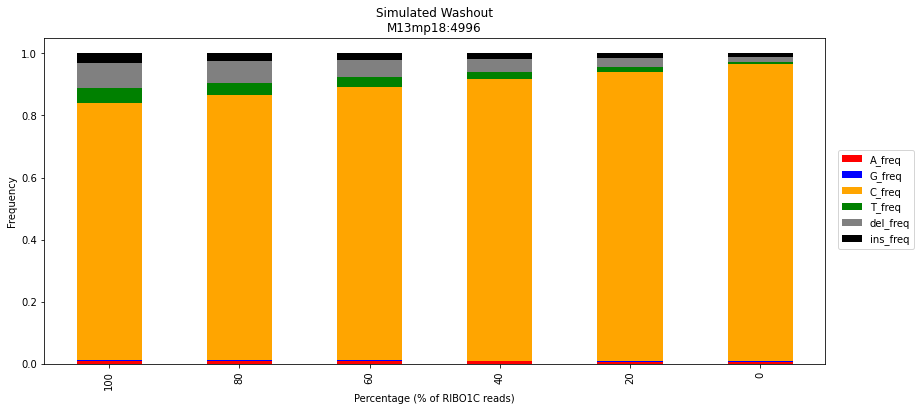

In [8]:
title = f"Simulated Washout\nM13mp18:{pos_1_based}"
df.plot(kind='bar', stacked=True, color=["red", "blue", "orange", "green", "gray", "black"], figsize=(14, 6))
plt.xlabel("Percentage (% of RIBO1C reads)")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.12, 0.67))
plt.title(title)

# save image to disk
plt.savefig("/lustre/bio_running/DNA_Ribo_2023/results/simulated_washout/sim_washout_DNA_vs_RIBO1C_site_M13mp18_4996.reverse.tiff", 
            dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

plt.show()